# Gold Price Forecasting using Machine Learning

## Overview
This project focuses on predicting gold prices using historical data and machine learning techniques. The dataset is retrieved from Yahoo Finance, and various technical indicators are calculated to enhance predictive accuracy. The model is trained using the k-Nearest Neighbors (k-NN) algorithm with multiple time-step forecasting.

The project includes the following steps:
1. **Data Collection and Preprocessing**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Engineering**
4. **Time Series Splitting**
5. **Model Training and Optimization**
6. **Forecast Evaluation**
7. **Visualization of Predictions**

## Code Breakdown

## 1. Data Collection and Preprocessing

The dataset is retrieved from Yahoo Finance using the `yfinance` package. The historical gold prices (symbol: `GC=F`) from February 2014 to February 2024 are loaded into a pandas DataFrame. After retrieving the data, the 'Date' column is converted to datetime format and the dataset is reset for further processing.


In [22]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
import ta

# Download historical data for gold prices
zloto = yf.Ticker("GC=F")
dane = zloto.history(start="2014-02-28", end="2024-02-29").reset_index()
dane['Date'] = pd.to_datetime(dane['Date']).dt.to_period('D')
dane['Date'] = dane['Date'].dt.to_timestamp()

# Selecting relevant columns
data_selected = dane[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']].copy()

C:\Users\samuk\AppData\Local\Temp\ipykernel_30692\817137942.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  dane['Date'] = pd.to_datetime(dane['Date']).dt.to_period('D')


## 2. Exploratory Data Analysis (EDA)

In this step, we explore the data by checking its structure, missing values, and by creating visualizations. Additionally, we define a function analyze_dataset that prints statistics, calculates returns, and generates plots (line plot, histogram, and returns histogram).

Data shape: (2514, 6)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2514 non-null   datetime64[ns]
 1   Close   2514 non-null   float64       
 2   Open    2514 non-null   float64       
 3   High    2514 non-null   float64       
 4   Low     2514 non-null   float64       
 5   Volume  2514 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.0 KB
None

Descriptive Statistics:
                                Date        Close         Open         High  \
count                           2514  2514.000000  2514.000000  2514.000000   
mean   2019-02-27 04:08:01.145584640  1502.643754  1502.668218  1509.649802   
min              2014-02-28 00:00:00  1050.800049  1053.699951  1062.000000   
25%              2016-08-25 06:00:00  1248.049988  1248.425018  1253.325043   
50%         

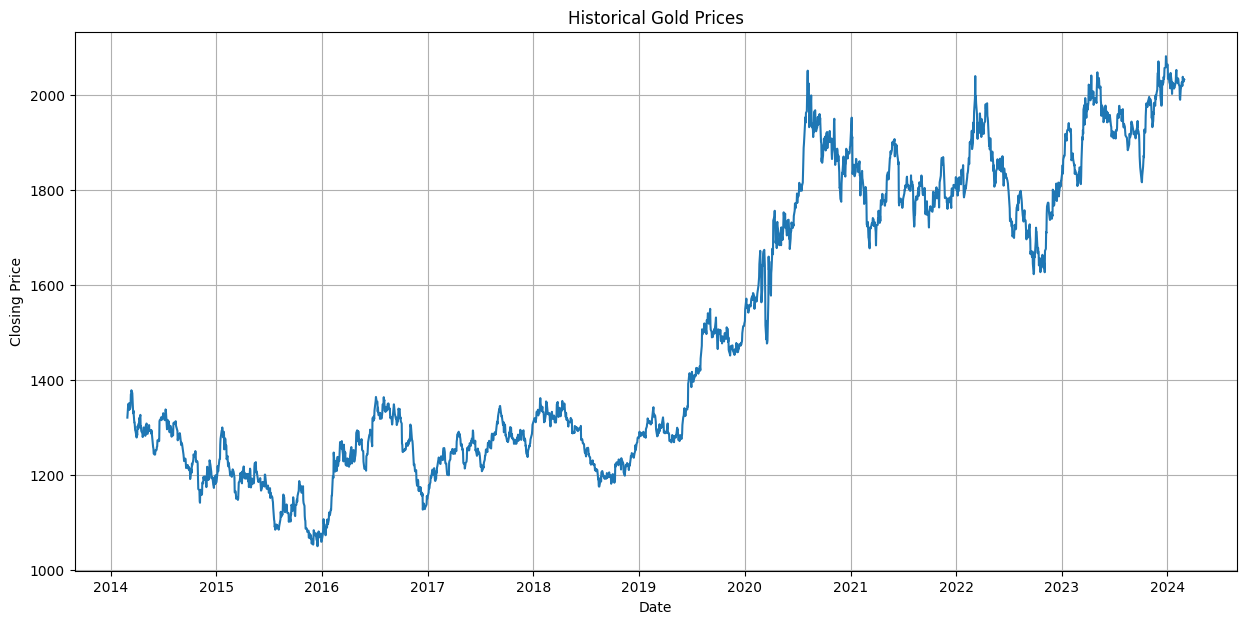

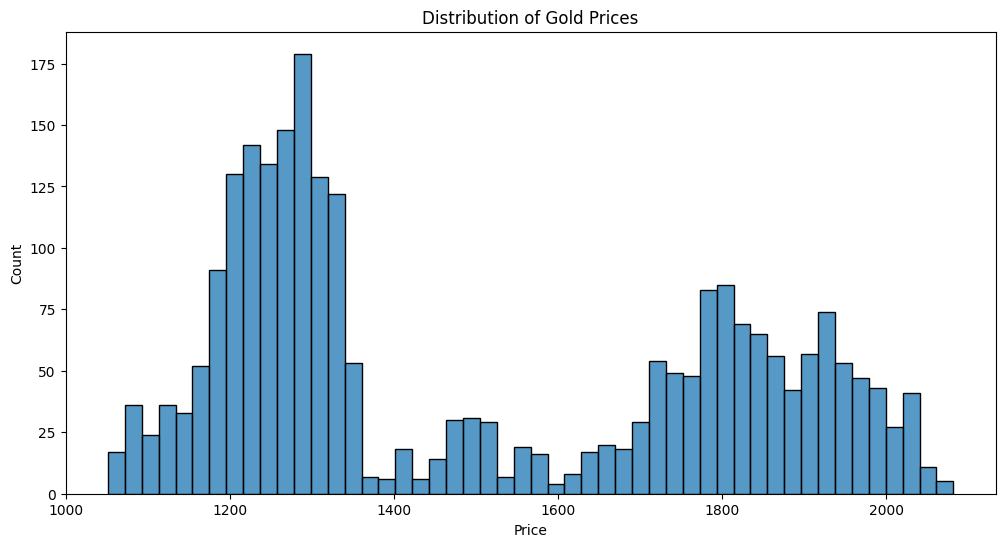

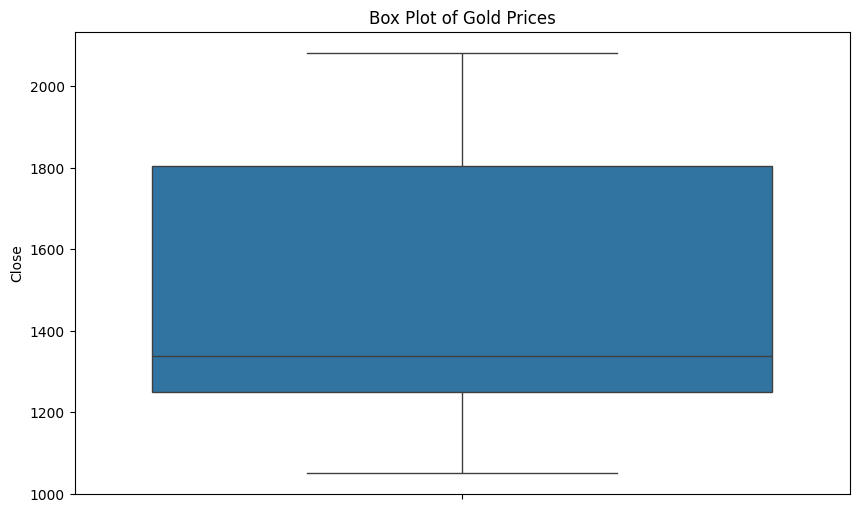

In [23]:
# Display basic information and statistics
print("Data shape:", data_selected.shape)
print("\nData Info:")
print(data_selected.info())
print("\nDescriptive Statistics:")
print(data_selected.describe())
print("\nMissing Values:")
print(data_selected.isnull().sum())

# Visualizations: line plot, histogram, and boxplot for the Close prices
plt.figure(figsize=(15, 7))
plt.plot(data_selected['Date'], data_selected['Close'])
plt.title('Historical Gold Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data_selected['Close'], bins=50)
plt.title('Distribution of Gold Prices')
plt.xlabel('Price')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(y=data_selected['Close'])
plt.title('Box Plot of Gold Prices')
plt.show()

# Function to analyze dataset (includes returns and visualizations)
def analyze_dataset(data, name):
    print(f"\nStatistics for Close prices in {name} dataset:")
    print(data['Close'].describe())
    
    # Calculate returns
    returns = data['Close'].pct_change()
    print(f"\nReturns statistics for {name} dataset:")
    print(returns.describe())
    
    # Plotting: prices, price distribution, and returns distribution
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    
    # Gold price trend
    ax1.plot(data.index, data['Close'])
    ax1.set_title(f'Gold Prices - {name} Set')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.grid(True)
    
    # Price distribution
    ax2.hist(data['Close'], bins=50)
    ax2.set_title(f'Price Distribution - {name} Set')
    ax2.set_xlabel('Price')
    ax2.set_ylabel('Frequency')
    
    # Returns distribution
    ax3.hist(returns.dropna(), bins=50)
    ax3.set_title(f'Returns Distribution - {name} Set')
    ax3.set_xlabel('Return')
    ax3.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return returns

## 3. Feature Engineering

In this step, we generate new features from the historical gold prices to enhance the model's ability to predict future prices. This includes technical indicators like moving averages, Relative Strength Index (RSI), Bollinger Bands, and price changes over different periods.

In [24]:
# Function for multi-step feature engineering
def tworzenie_cech_wielokrokowych(df, lag=5, steps=3):
    """
    Create advanced features for multi-step forecasting.
    For each row, generates targets for the next `steps` days.
    """
    df_cechy = df.copy()

    # Create target columns for multiple forecast steps
    for step in range(1, steps + 1):
        df_cechy[f'Cel_{step}'] = df_cechy['Close'].shift(-step)
    
    # Technical indicators
    df_cechy['SMA_5'] = ta.trend.sma_indicator(df_cechy['Close'], window=5)
    df_cechy['SMA_20'] = ta.trend.sma_indicator(df_cechy['Close'], window=20)
    df_cechy['SMA_50'] = ta.trend.sma_indicator(df_cechy['Close'], window=50)
    df_cechy['RSI'] = ta.momentum.rsi(df_cechy['Close'], window=14)
    
    macd = ta.trend.MACD(df_cechy['Close'])
    df_cechy['MACD'] = macd.macd()
    df_cechy['MACD_signal'] = macd.macd_signal()
    
    bollinger = ta.volatility.BollingerBands(df_cechy['Close'])
    df_cechy['BB_high'] = bollinger.bollinger_hband()
    df_cechy['BB_low'] = bollinger.bollinger_lband()
    
    # Price changes over different periods
    df_cechy['Price_Change_1d'] = df_cechy['Close'].pct_change(1)
    df_cechy['Price_Change_5d'] = df_cechy['Close'].pct_change(5)
    df_cechy['Price_Change_20d'] = df_cechy['Close'].pct_change(20)
    
    # Lag features
    for i in range(1, lag + 1):
        df_cechy[f'Close_Lag_{i}'] = df_cechy['Close'].shift(i)
    
    # Drop rows with missing values
    df_clean = df_cechy.dropna()
    
    # Select feature columns (exclude original price columns and targets)
    feature_columns = [col for col in df_clean.columns if col not in ['Date', 'Close', 'Volume'] +
                       [f'Cel_{step}' for step in range(1, steps + 1)]]
    
    X = df_clean[feature_columns]
    y = df_clean[[f'Cel_{step}' for step in range(1, steps + 1)]]
    
    return X, y


## 4. Time Series Splitting

We split the data into training and testing sets (80% training, 20% testing). We also call analyze_dataset for both sets to inspect their properties.


Statistics for Close prices in Training dataset:
count    2011.000000
mean     1406.673296
std       251.690934
min      1050.800049
25%      1226.500000
50%      1295.800049
75%      1583.450012
max      2051.500000
Name: Close, dtype: float64

Returns statistics for Training dataset:
count    2010.000000
mean        0.000220
std         0.009241
min        -0.049787
25%        -0.004177
50%         0.000246
75%         0.004911
max         0.059477
Name: Close, dtype: float64


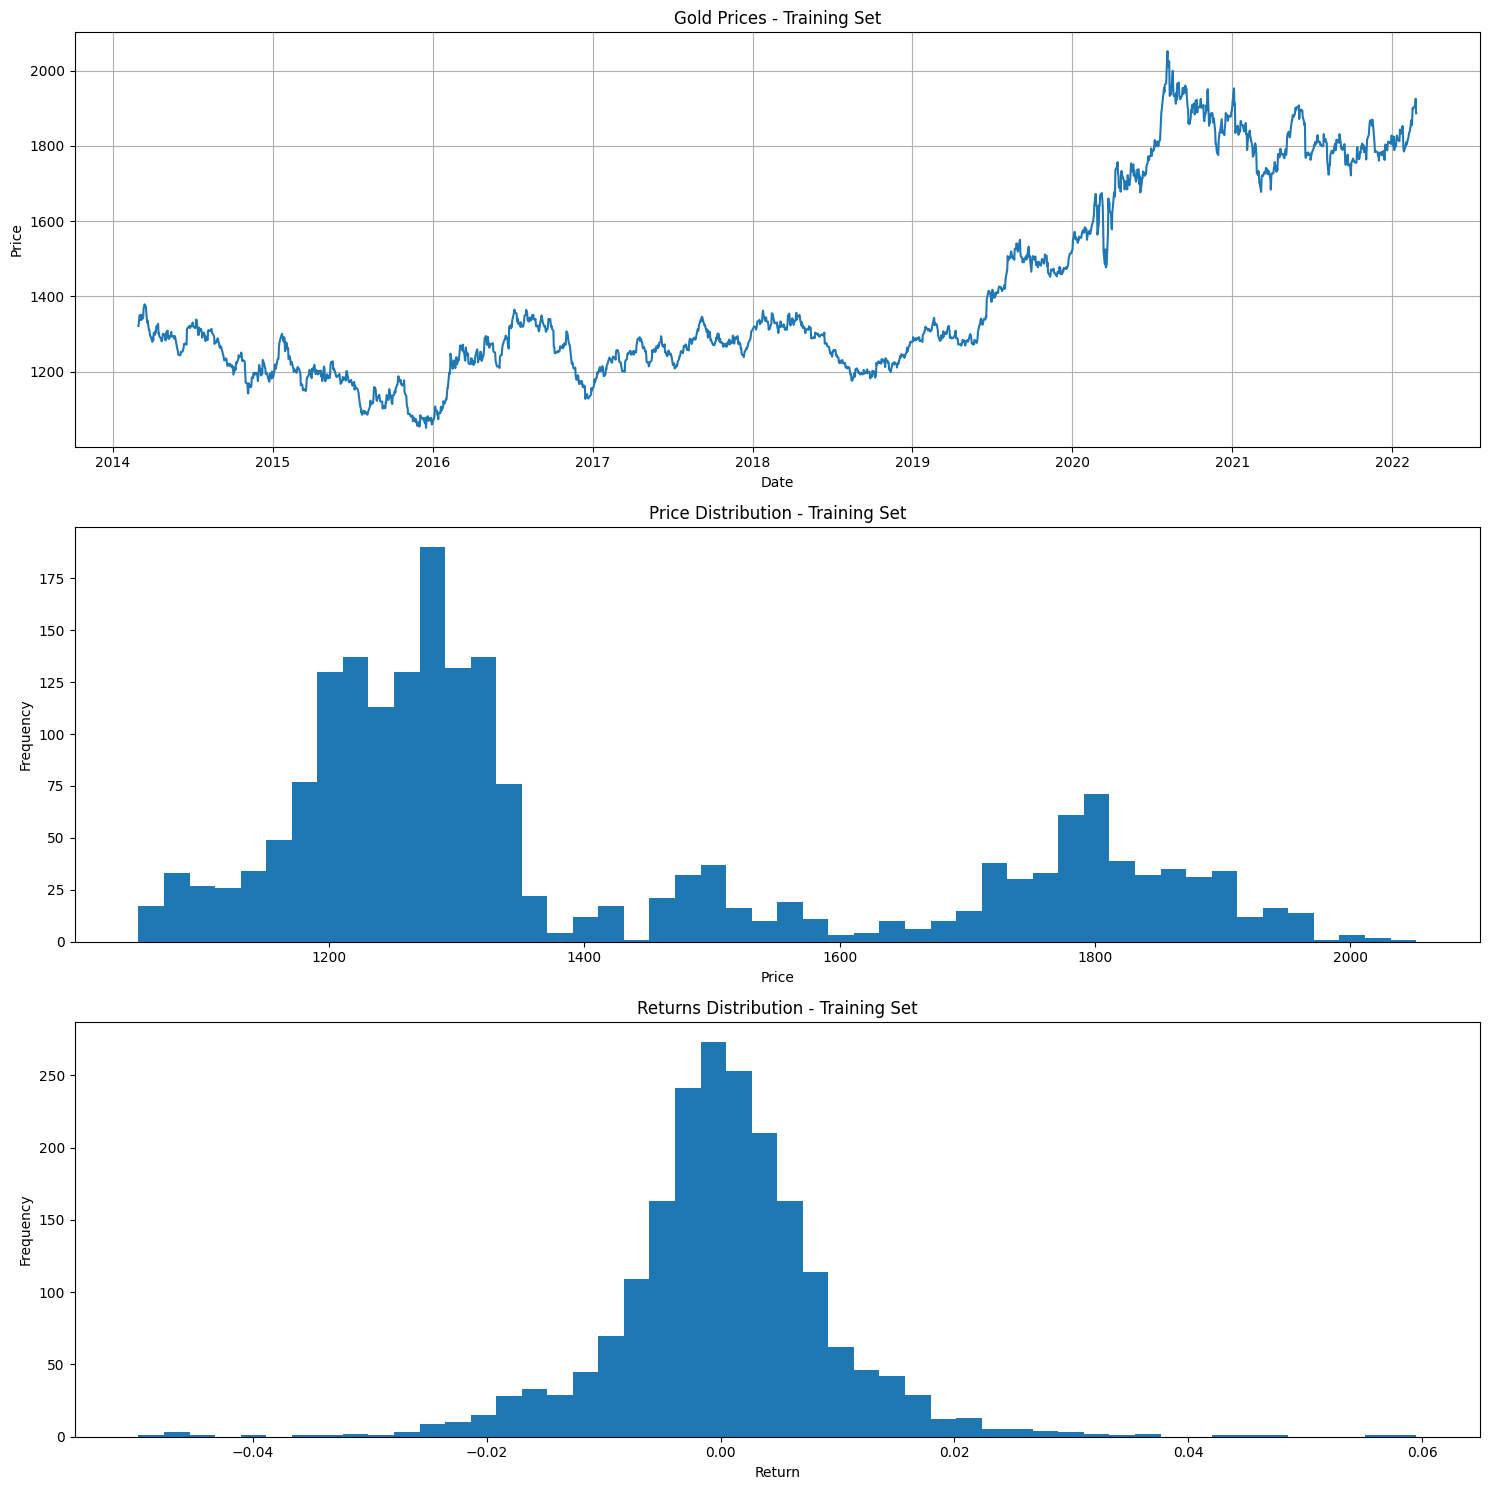


Statistics for Close prices in Test dataset:
count     503.000000
mean     1886.334790
std       112.496759
min      1623.300049
25%      1813.099976
50%      1918.199951
75%      1977.349976
max      2081.899902
Name: Close, dtype: float64

Returns statistics for Test dataset:
count    502.000000
mean       0.000175
std        0.008891
min       -0.027866
25%       -0.004690
50%        0.000104
75%        0.004813
max        0.031558
Name: Close, dtype: float64


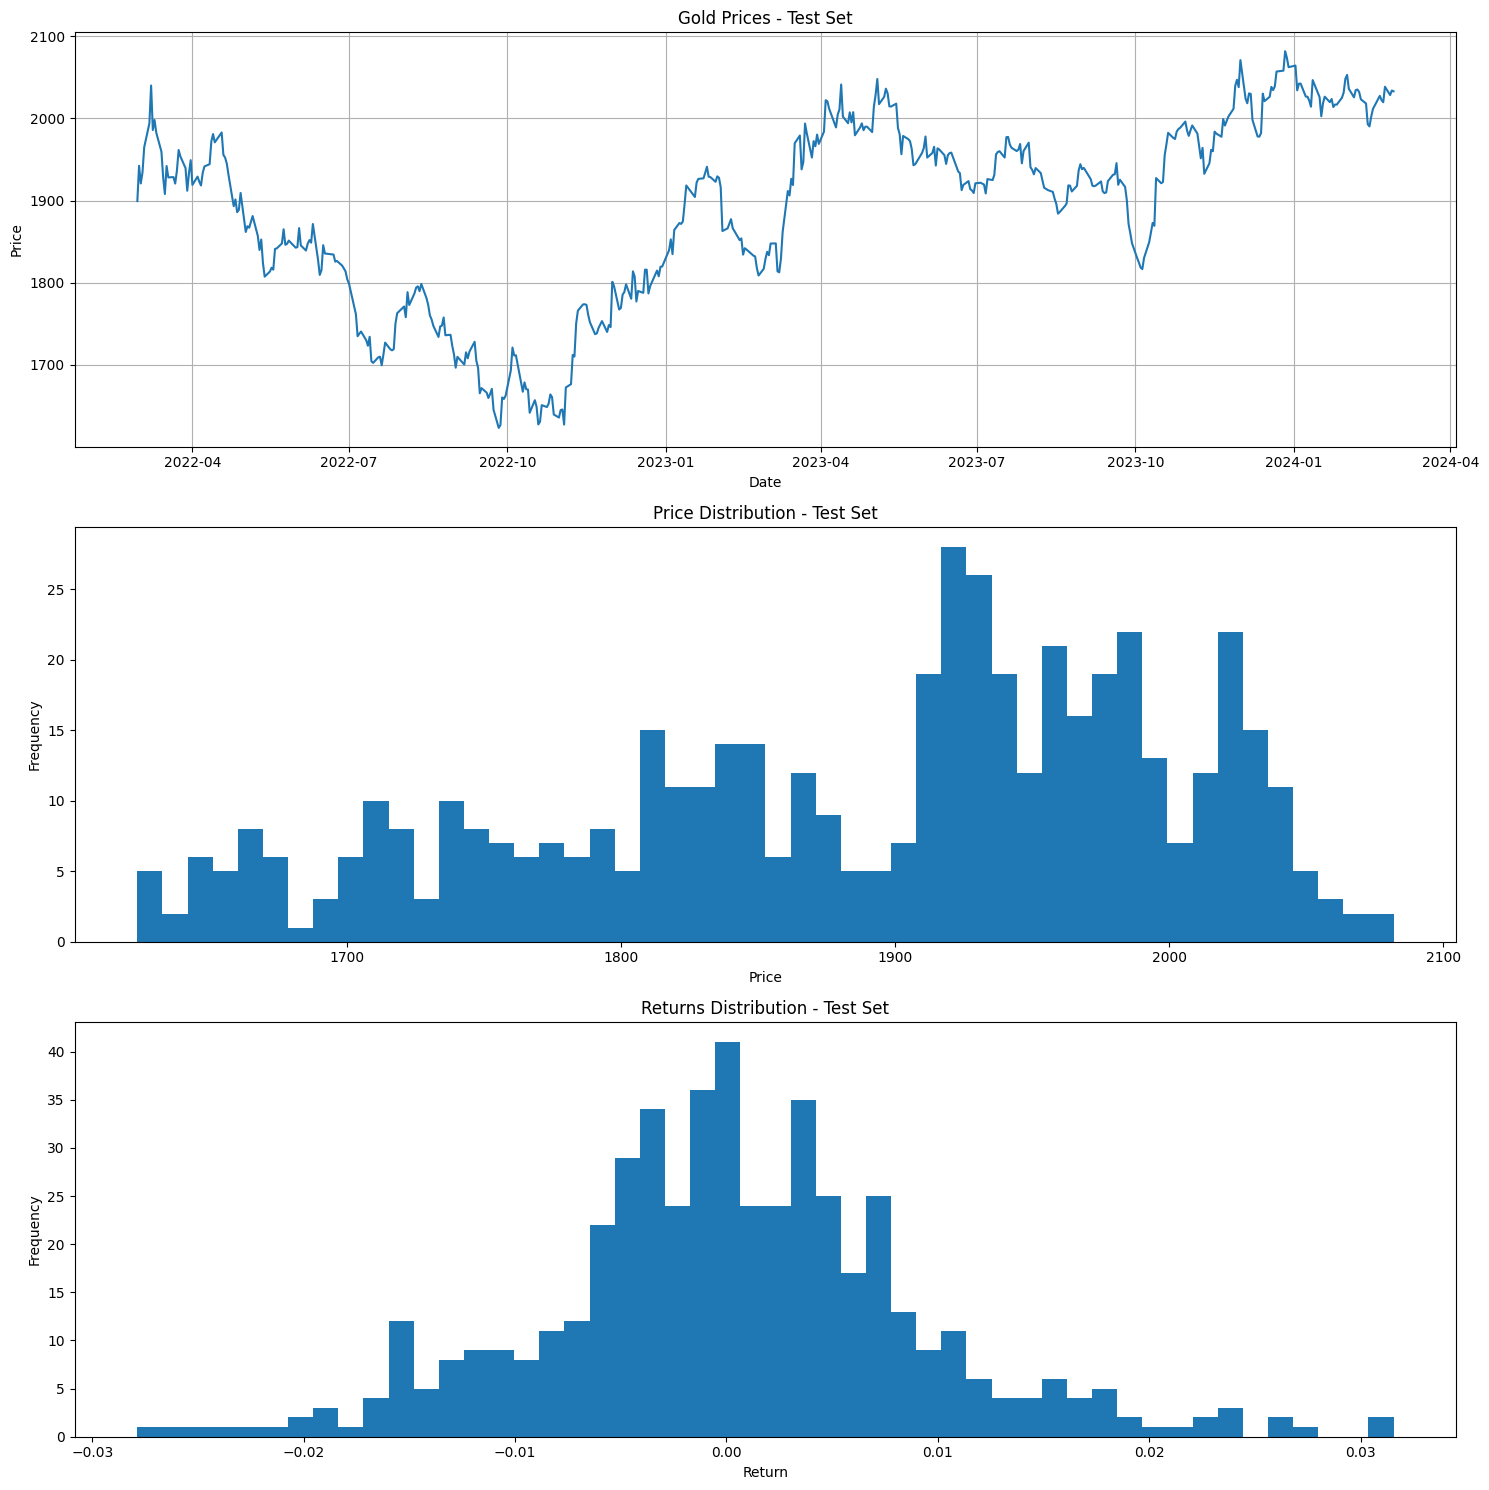


Comparison of Statistics between Training and Test Sets:
             Train         Test
count  2011.000000   503.000000
mean   1406.673296  1886.334790
std     251.690934   112.496759
min    1050.800049  1623.300049
25%    1226.500000  1813.099976
50%    1295.800049  1918.199951
75%    1583.450012  1977.349976
max    2051.500000  2081.899902


In [25]:
# Set Date as index for time series operations
data_selected = data_selected.set_index('Date')

# Split the data: 80% for training, 20% for testing
total_size = len(data_selected)
train_size = int(total_size * 0.8)
data_train = data_selected[:train_size]
data_test = data_selected[train_size:]

# Analyze both training and test datasets
returns_train = analyze_dataset(data_train, 'Training')
returns_test = analyze_dataset(data_test, 'Test')

# Compare basic statistics between training and test sets
comparison_df = pd.DataFrame({
    'Train': data_train['Close'].describe(),
    'Test': data_test['Close'].describe()
})
print("\nComparison of Statistics between Training and Test Sets:")
print(comparison_df)

## 5. Model Training and Optimization

We use the k-Nearest Neighbors (k-NN) regressor for forecasting. Hyperparameter tuning is performed with GridSearchCV using TimeSeriesSplit. The model is trained for each forecast step (multi-step forecasting).


In [26]:
# Define number of forecast steps (e.g., 3 days ahead)
steps = 3

# Create features for multi-step forecasting
X_train, y_train = tworzenie_cech_wielokrokowych(data_train, lag=5, steps=steps)
X_test, y_test = tworzenie_cech_wielokrokowych(data_test, lag=5, steps=steps)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for k-NN
param_grid = {
    'n_neighbors': range(3, 31, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Setup TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
knn = KNeighborsRegressor()
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

# Train a separate model for each forecast step
y_preds = []  # To store predictions for each step

for step in range(steps):
    print(f"Training model for forecast step {step + 1}...")
    y_step_train = y_train.iloc[:, step]
    y_step_test = y_test.iloc[:, step]
    
    grid_search.fit(X_train_scaled, y_step_train)
    y_step_pred = grid_search.predict(X_test_scaled)
    y_preds.append(y_step_pred)
    
    mse = mean_squared_error(y_step_test, y_step_pred)
    mae = mean_absolute_error(y_step_test, y_step_pred)
    r2 = r2_score(y_step_test, y_step_pred)
    print(f"Step {step + 1}: MSE = {mse}, MAE = {mae}, R2 = {r2}")
    print(f"Best parameters for step {step + 1}: {grid_search.best_params_}")

Training model for forecast step 1...
Step 1: MSE = 3480.176008367465, MAE = 48.24894287447268, R2 = 0.743207547380802
Best parameters for step 1: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Training model for forecast step 2...
Step 2: MSE = 4094.819613732479, MAE = 53.223121280887604, R2 = 0.6989300017136477
Best parameters for step 2: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Training model for forecast step 3...
Step 3: MSE = 4757.928871020522, MAE = 57.27998756336281, R2 = 0.6514394962486463
Best parameters for step 3: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


## 6. Forecast Evaluation

The performance of the model is evaluated using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score for each forecast step. These metrics are printed during the training loop above.

## 7. Visualization of Predictions

Finally, we visualize the predicted and actual gold prices for each forecast step. The predictions are plotted against the true prices to assess the accuracy visually.

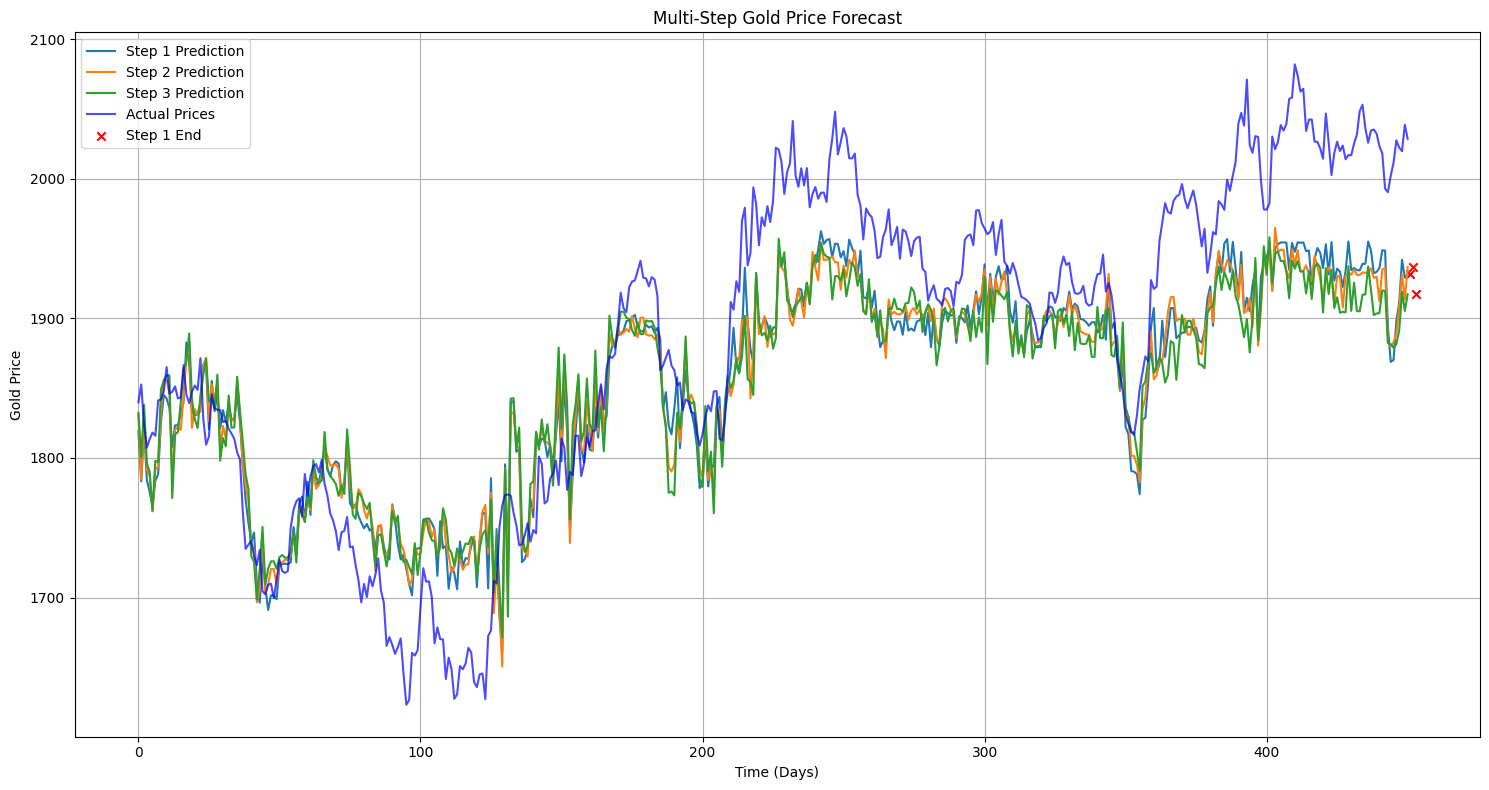

In [27]:
plt.figure(figsize=(15, 8))

# Plot predictions for each forecast step
for step in range(steps):
    plt.plot(range(len(y_preds[step])), y_preds[step], label=f'Step {step + 1} Prediction')

# Plot the actual gold prices (using the first forecast step as reference)
plt.plot(range(len(y_test)), y_test.iloc[:, 0], label='Actual Prices', color='blue', alpha=0.7)

# Mark the final prediction point for each forecast step
for step in range(steps):
    end_point = len(y_test) + step
    plt.scatter(end_point, y_preds[step][-1], color='red', marker='x', 
                label=f'Step {step + 1} End' if step == 0 else "")

plt.title('Multi-Step Gold Price Forecast')
plt.xlabel('Time (Days)')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion
This project successfully implements a multi-step forecasting model for gold prices using k-NN regression. The model is optimized through hyperparameter tuning, and results are visualized to compare predictions against actual market data. The approach can be further refined using deep learning models such as LSTMs or transformers for improved long-term forecasting.

---
**Next Steps:**
- Experimenting with other regression models (e.g., XGBoost, LSTMs)
- Incorporating external features (e.g., macroeconomic indicators)
- Testing different feature engineering techniques

This project serves as a strong foundation for financial time series forecasting and can be expanded upon in future research.

